# Exploring Cluster Composition Across Easy-Cluster Parameter Settings

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
import re

In [2]:
# import protein metadata
metadata = pd.read_csv('../data/protein_metadata.csv')

In [3]:
metadata[10:11]

,genome_accn,protein_accn,phage,function,protein,pLDDT,PFAM1,PFAM1_description,PFAM1_definition,protein_id,protein_length
10,NC_028834,YP_009201743.1,Achromobacter phage 83-24,major head protein,YP_009201743,82.198187,PF20036,This family represents phage capsid/coat prote...,Major capsid protein 13-like,YP_009201743.1,344.0


In [4]:
genome_metadata = pd.read_csv('../data/genome_ncbi_metadata_with_taxonomy.csv')

In [5]:
genome_metadata[0:1]

,genome_accn,genome_name,genome_length,total_proteins,taxonomy_string
0,BK063677,TPA_asm: Caudoviricetes sp. vir080 genomic seq...,53200,72,Viruses; Duplodnaviria; Heunggongvirae; Urovir...


In [6]:
ictv_metadata = pd.read_csv('../data/4083_ICTV_metadata.csv')

In [7]:
ictv_metadata[0:1]

,Sort,Isolate Sort,Realm,Subrealm,Kingdom,Subkingdom,Phylum,Subphylum,Class,Subclass,...,Exemplar virus name,Exemplar isolate designation,Host/Source,Change,source_file,Virus name abbreviation,Proposed Rank,GenBank,submission_year,genome_accn
0,2415.0,1.0,Duplodnaviria,NaN,Heunggongvirae,NaN,Uroviricota,NaN,Caudoviricetes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NC_021317


In [13]:
# 80 families in the dataset (ICTV VMR40)
len(ictv_metadata.Family.dropna().unique())

80

In [14]:
# 11 caudoviricetes orders (+ 1 outgroup)
len(ictv_metadata.Order.dropna().unique())

12

In [15]:
ictv_metadata_families = ictv_metadata.dropna(subset='Family')
ictv_metadata_orders = ictv_metadata.dropna(subset='Order')

In [16]:
genome_metadata = genome_metadata[genome_metadata.genome_accn.isin(ictv_metadata.genome_accn.to_list())]

In [12]:
def annotate_clusters(clu, protein_metadata):
    """
    Annotates protein clusters with metadata from a provided protein metadata DataFrame.

    Parameters:
    ----------
    clu : pd.DataFrame
        DataFrame containing Foldseek easy-cluster output - two columns: 'cluster' and 'members', which represent clustered 
        protein identifiers.
    
    protein_metadata : pd.DataFrame
        DataFrame containing metadata for proteins, including genome accession, phage status, 
        function, pLDDT score, PFAM annotations, and protein length.

    Returns:
    -------
    pd.DataFrame
        Annotated cluster DataFrame where each row represents a pair of cluster-member relationships, 
        enriched with metadata for both the cluster and its members.
    """
    clu.columns = ['cluster', 'members']
    clu['cluster'] = clu['cluster'].str.replace('.pdb', '', regex=True)
    clu['members'] = clu['members'].str.replace('.pdb', '', regex=True)
    
    metadata_cols = ['protein_accn', 'genome_accn', 'phage', 'function', 'pLDDT', 'PFAM1', 
                     'PFAM1_description', 'PFAM1_definition', 'protein_length']
    protein_metadata_cleaned = protein_metadata[metadata_cols].copy()

    # Merge for cluster metadata
    clu = clu.merge(protein_metadata_cleaned, left_on='cluster', right_on='protein_accn', how='left') \
        .rename(columns={'genome_accn': 'cluster_genome_accn', 'phage': 'cluster_phage',
                         'function': 'cluster_function', 'pLDDT': 'cluster_pLDDT',
                         'PFAM1': 'cluster_PFAM1', 'PFAM1_description': 'cluster_PFAM1_description',
                         'PFAM1_definition': 'cluster_PFAM1_definition','protein_length':'cluster_protein_length'}) \
        .drop(['protein_accn'], axis=1)

    # Merge for member metadata
    clu = clu.merge(protein_metadata_cleaned, left_on='members', right_on='protein_accn', how='left') \
        .rename(columns={'genome_accn': 'member_genome_accn', 'phage': 'member_phage',
                         'function': 'member_function', 'pLDDT': 'member_pLDDT',
                         'PFAM1': 'member_PFAM1', 'PFAM1_description': 'member_PFAM1_description',
                         'PFAM1_definition': 'member_PFAM1_definition','protein_length':'member_protein_length'}) \
        .drop(['protein_accn'], axis=1)

    # Remove self-matches and duplicates
    clu = clu.drop_duplicates(subset=['cluster', 'members'], keep='first')
    clu = clu[clu.cluster != clu.members]

    # Filter out clusters with fewer than 2 members
    cluster_counts = clu.groupby('cluster')['member_genome_accn'].transform('count')
    clu = clu[cluster_counts >= 2]

    return clu

In [13]:
def group_clusters(df):
    df_grouped = df.groupby('cluster').agg({'members': 'count', 'cluster_function': 'first',\
                                           'member_PFAM1_definition':'first'})\
                            .reset_index().sort_values(by=['members'], ascending=False)\
                            .reset_index(drop=True)
    return df_grouped

def group_clusters_taxonomy(df, ictv_metadata):
    merged_df = df.merge(
        ictv_metadata,
        left_on='member_genome_accn',
        right_on='genome_accn',
        how='left'  
    )
    merged_df['Family'] = merged_df['Family'].fillna('Unclassified_Family')

    df_grouped = merged_df.groupby('cluster').agg({'member_genome_accn': 'nunique', 'cluster_function': 'first',\
                                           'cluster_PFAM1_definition':'first',
                                           'member_PFAM1_definition':'first',
                                           'Family':'nunique'})\
                            .reset_index().sort_values(by=['member_genome_accn'], ascending=False)\
                            .reset_index(drop=True)
    df_grouped.rename(columns={'Family': 'unique_family_count','member_genome_accn':'unique_genome_count'}, inplace=True)
    return df_grouped

def group_clusters_taxonomy_orders(df, ictv_metadata):
    merged_df = df.merge(
        ictv_metadata,
        left_on='member_genome_accn',
        right_on='genome_accn',
        how='left'
    )

    merged_df['Order'] = merged_df['Order'].fillna('Unclassified_Family')

    def unique_orders(series):
        return list(series.dropna().unique())

    df_grouped = merged_df.groupby('cluster').agg({
        'member_genome_accn': 'nunique',
        'cluster_function': 'first',
        'cluster_PFAM1_definition': 'first',
        'member_PFAM1_definition': 'first',
        'cluster_protein_length': 'first',   
        'Order': unique_orders
    }).reset_index().sort_values(by='member_genome_accn', ascending=False).reset_index(drop=True)

    df_grouped.rename(columns={
        'Order': 'unique_orders',
        'member_genome_accn': 'unique_genome_count'
    }, inplace=True)

    return df_grouped

def get_missing_families(merged_df, df_grouped, top_n=10):
    # Get all unique families
    all_families = merged_df['Family'].unique()
    total_expected_families = len(all_families)
    # Initialize a dictionary to store missing families for each cluster
    missing_families_per_cluster = {}

    # Iterate over each cluster in the top N clusters
    for cluster in df_grouped['cluster'].head(top_n):
        # Families found in this cluster
        families_in_cluster = merged_df[merged_df['cluster'] == cluster]['Family'].unique()
        
        # Identify families missing in this cluster
        missing_families = set(all_families) - set(families_in_cluster)
        
        # Store missing families if they don't meet the expected count
        if len(families_in_cluster) < total_expected_families:
            missing_families_per_cluster[cluster] = list(missing_families)
    
    return missing_families_per_cluster

In [19]:
def group_clusters_taxonomy_fams(df, ictv_metadata):
    # Merge the two dataframes on the appropriate columns
    merged_df = df.merge(
        ictv_metadata,
        left_on='member_genome_accn',
        right_on='genome_accn',
        how='left'  
    )

    # Fill NaN values in the 'Family' column with 'Unclassified_Family'
    merged_df['Family'] = merged_df['Family'].fillna('Unclassified_Family')

    # Group by 'cluster' and aggregate the necessary fields
    df_grouped = merged_df.groupby('cluster').agg({
        'member_genome_accn': 'nunique',  # Count unique genomes
        'cluster_function': 'first',  # Take the first function
        'cluster_PFAM1_definition': 'first',  # Take the first PFAM definition
        'member_PFAM1_definition': 'first',  # Take the first member PFAM definition
        'Family': lambda x: sorted(list(set(x))),  # Get the unique list of families
        'cluster_protein_length':'first'
    }).reset_index().sort_values(by=['member_genome_accn'], ascending=False).reset_index(drop=True)

    # Add a column to count the number of unique families
    df_grouped['unique_family_count'] = df_grouped['Family'].apply(len)
    
    # Rename the columns to be more descriptive
    df_grouped.rename(columns={
        'Family': 'unique_families',  # Renaming to 'unique_families' to indicate it's a list
        'member_genome_accn': 'unique_genome_count'  # Renaming to show it counts unique genomes
    }, inplace=True)

    return df_grouped

In [20]:
def clean_definitions(df):
    # Function to find the mode of a series, returning the first mode if there are multiple
    def find_mode(series):
        modes = series.mode()
        return modes[0] if not modes.empty else None

    # Group by 'cluster' and find the most frequent mode for 'member_PFAM1_definition'
    mode_df = df.groupby('cluster')['member_PFAM1_definition'].agg(find_mode).reset_index()
    mode_df.rename(columns={'member_PFAM1_definition': 'most_frequent'}, inplace=True)

    # Merge the mode back into the original DataFrame on 'cluster'
    df = df.merge(mode_df, on='cluster', how='left')

    # Define a function to determine valid cluster definitions
    def get_cluster_definition(row):
        if row['cluster_function'] == 'portal protein':
            return 'portal protein'
        elif row['cluster_function'] == 'major head protein':
            return 'major capsid protein'
        elif isinstance(row['most_frequent'], str) and 'unknown' not in row['most_frequent'].lower():
            return row['most_frequent']
        else:
            return row['cluster_function']

    # Apply the function to create the initial cluster_definition
    df.loc[:, 'cluster_definition'] = df.apply(get_cluster_definition, axis=1)
    df = df[df['cluster_definition'].notna()]

    # Use the most frequent definition for rows where member_PFAM1_definition length is less than 3
    df.loc[df['member_PFAM1_definition'].str.len() < 3, 'cluster_definition'] = df['most_frequent']

    # Split on the first comma, take the first part, and capitalize only the first letter
    df.loc[:, 'cluster_definition'] = df['cluster_definition'].str.split(',').str[0]
    df.loc[:, 'cluster_definition'] = df['cluster_definition'].str[0].str.upper() + df['cluster_definition'].str[1:]

    # Filter out invalid cluster definitions that are numeric or too short
    df = df[~df['cluster_definition'].str.isnumeric()]
    df = df[df['cluster_definition'].str.len() > 1]  # Ensuring cluster definitions are longer than 1 character

    # Create the cluster_ID
    df.loc[:, 'cluster_ID'] = df['cluster'].astype(str) + ':' + df['cluster_definition'].astype(str)

    return df

# 1. Import range of foldseek easy-cluster parameter run outputs for cluster specificity and RMSD composition analysis

In [11]:
import os
# test_thresholds folder is zipped -> need to unzip to access
data_dir = '../data/foldseek_easy_cluster/test_thresholds/'
files = os.listdir(data_dir)

# Dictionary to hold DataFrames
dfs = {}

for filename in files:
    if filename.startswith('cov') and filename.endswith('.tsv'):
        var_name = filename.replace('.tsv', '')
        file_path = os.path.join(data_dir, filename)
        dfs[var_name] = pd.read_csv(file_path, sep='\t', header=None)

In [15]:
from tqdm import tqdm

annotated_dfs = {}

for name, df in tqdm(dfs.items(), desc="Annotating clusters"):
    annotated_name = f"{name}_annot"
    annotated_dfs[annotated_name] = annotate_clusters(df, metadata)

# Example access:
# annotated_dfs['cov0_c0.25_tm0.3_re1_e1e-2_cluster_annot']

Annotating clusters: 100%|█████████████████████████████████████████████████████████████| 52/52 [01:52<00:00,  2.17s/it]


In [16]:
# example annotated output
group_clusters_taxonomy(annotated_dfs['cov5_c0.3_re1_e1e-2__cluster_annot'], ictv_metadata)[0:1]

,cluster,unique_genome_count,cluster_function,cluster_PFAM1_definition,member_PFAM1_definition,unique_family_count
0,YP_008320485.1,3245,major head protein,Phage capsid family,Phage capsid family,67


# Approach:
#### * Use known conserved proteins (MCP, portal, TerL) as internal controls to calibrate Foldseek clustering parameters, and then validate with functional specificity (Pfam entropy). 

#### * Since some Pfams represent the same function, calculating entropy on raw member_PFAM1 overestimates functional diversity -> Define functional equivalence groups - Map functionally similar Pfams to a single representative label for entropy calculation. 

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from tqdm import tqdm

# Define PFAM marker keywords and aliases
marker_keywords = {
    'MCP': ['capsid', 'coat', 'coat protein', 'nucleocapsid'],
    'Portal': ['portal'],
    'TerL': ['terminase', 'terl', 'rnase']
}

marker_aliases = {
    "capsid": ["major head", "capsid"],
    "portal": ["portal"],
    "terminase": ["terminase"]
}

# Create PFAM mapping from member_PFAM1_definition
def generate_pfam_mapping(df, keyword_dict):
    mapping = {}
    pfam_defs = df[['member_PFAM1', 'member_PFAM1_definition']].dropna().drop_duplicates()

    for _, row in pfam_defs.iterrows():
        pfam = row['member_PFAM1']
        definition = str(row['member_PFAM1_definition']).lower()
        for label, keywords in keyword_dict.items():
            if any(kw in definition for kw in keywords):
                mapping[pfam] = label
                break
    return mapping

# Functional specificity calc using mapped categories
def functional_specificity_corrected(pfam_series, mapping_dict):
    mapped = pfam_series.map(mapping_dict).fillna(pfam_series) 
    mapped = mapped.dropna()
    if mapped.empty:
        return np.nan
    values, counts = np.unique(mapped, return_counts=True)
    proportions = counts / counts.sum()
    if len(values) == 1:
        return 1.0
    h = entropy(proportions)
    h_max = np.log(len(values))
    return 1 - h / h_max

results = []

for name, df in tqdm(annotated_dfs.items(), desc="Processing annotated runs"):
    print(f"Processing: {name}")
    
    df = df[df['cluster'].notna()]  # Drop rows without cluster IDs

    # Generate marker PFAM mapping for this run
    pfam_mapping = generate_pfam_mapping(df, marker_keywords)

    # Compute specificity for each cluster using corrected labels
    spec = df.groupby('cluster')['member_PFAM1'].apply(lambda x: functional_specificity_corrected(x, pfam_mapping))
    mean_spec = spec.mean()
    n_clusters = df['cluster'].nunique()

    marker_summary = {}
    for marker_label, aliases in marker_aliases.items():
        pattern = "|".join(aliases)

        marker_df = df[
            df['member_function'].str.lower().str.contains(pattern.lower(), na=False, regex=True) |
            df['cluster_PFAM1_definition'].str.lower().str.contains(pattern.lower(), na=False, regex=True)
        ]

        if not marker_df.empty:
            cluster_counts = marker_df.groupby('cluster')['member_genome_accn'].count()
            if not cluster_counts.empty:
                top_cluster = cluster_counts.idxmax()
                cluster_size = cluster_counts.max()
                cluster_spec = spec.get(top_cluster, np.nan)

                cluster_function = df[df['cluster'] == top_cluster]['cluster_function'].mode().iloc[0]
                top_cluster_with_function = f"{top_cluster}_{cluster_function}"
            else:
                top_cluster_with_function = None
                cluster_size = 0
                cluster_spec = np.nan
        else:
            top_cluster_with_function = None
            cluster_size = 0
            cluster_spec = np.nan

        marker_summary[f"{marker_label}_cluster"] = top_cluster_with_function
        marker_summary[f"{marker_label}_size"] = cluster_size
        marker_summary[f"{marker_label}_specificity"] = cluster_spec

    results.append({
        "run": name.replace("_cluster_annot", ""),
        "mean_specificity": mean_spec,
        "n_clusters": n_clusters,
        **marker_summary
    })

summary_df = pd.DataFrame(results)
summary_df.head()

Processing annotated runs:   0%|                                                                | 0/52 [00:00<?, ?it/s]

Processing: cov5_c0.3_re1_e1e-2__cluster_annot


Processing annotated runs:   2%|█                                                       | 1/52 [00:11<09:41, 11.40s/it]

Processing: cov5_c0.3_re1_e1e-3__cluster_annot


Processing annotated runs:   4%|██▏                                                     | 2/52 [00:23<10:04, 12.08s/it]

Processing: cov5_c0.3_re1_e1e-4__cluster_annot


Processing annotated runs:   6%|███▏                                                    | 3/52 [00:38<10:38, 13.03s/it]

Processing: cov5_c0.3_re1_e1e-5__cluster_annot


Processing annotated runs:   8%|████▎                                                   | 4/52 [00:53<11:11, 13.99s/it]

Processing: cov5_c0.3_tm0.3_re1_e1e-2_minseqid_0.05_cluster_annot


Processing annotated runs:  10%|█████▍                                                  | 5/52 [01:06<10:46, 13.75s/it]

Processing: cov5_c0.3_tm0.3_re1_e1e-2__cluster_annot


Processing annotated runs:  12%|██████▍                                                 | 6/52 [01:20<10:25, 13.59s/it]

Processing: cov5_c0.3_tm0.3_re1_e1e-3__cluster_annot


Processing annotated runs:  13%|███████▌                                                | 7/52 [01:34<10:18, 13.74s/it]

Processing: cov5_c0.3_tm0.3_re1_e1e-4__cluster_annot


Processing annotated runs:  15%|████████▌                                               | 8/52 [01:49<10:25, 14.22s/it]

Processing: cov5_c0.3_tm0.3_re1_e1e-5__cluster_annot


Processing annotated runs:  17%|█████████▋                                              | 9/52 [02:04<10:26, 14.57s/it]

Processing: cov5_c0.4_re1_e1e-2__cluster_annot


Processing annotated runs:  19%|██████████▌                                            | 10/52 [02:18<09:57, 14.23s/it]

Processing: cov5_c0.4_re1_e1e-3__cluster_annot


Processing annotated runs:  21%|███████████▋                                           | 11/52 [02:32<09:41, 14.18s/it]

Processing: cov5_c0.4_re1_e1e-4__cluster_annot


Processing annotated runs:  23%|████████████▋                                          | 12/52 [02:46<09:29, 14.23s/it]

Processing: cov5_c0.4_re1_e1e-5__cluster_annot


Processing annotated runs:  25%|█████████████▊                                         | 13/52 [03:01<09:17, 14.29s/it]

Processing: cov5_c0.4_tm0.3_re1_e1e-2_minseqid_0.1_cluster_annot


Processing annotated runs:  27%|██████████████▊                                        | 14/52 [03:15<09:05, 14.35s/it]

Processing: cov5_c0.4_tm0.3_re1_e1e-2__cluster_annot


Processing annotated runs:  29%|███████████████▊                                       | 15/52 [03:29<08:49, 14.31s/it]

Processing: cov5_c0.4_tm0.3_re1_e1e-3__cluster_annot


Processing annotated runs:  31%|████████████████▉                                      | 16/52 [03:44<08:36, 14.35s/it]

Processing: cov5_c0.4_tm0.3_re1_e1e-4__cluster_annot


Processing annotated runs:  33%|█████████████████▉                                     | 17/52 [03:58<08:18, 14.25s/it]

Processing: cov5_c0.4_tm0.3_re1_e1e-5__cluster_annot


Processing annotated runs:  35%|███████████████████                                    | 18/52 [04:13<08:11, 14.46s/it]

Processing: cov5_c0.5_re1_e1e-2__cluster_annot


Processing annotated runs:  37%|████████████████████                                   | 19/52 [04:26<07:41, 13.98s/it]

Processing: cov5_c0.5_re1_e1e-3__cluster_annot


Processing annotated runs:  38%|█████████████████████▏                                 | 20/52 [04:41<07:38, 14.33s/it]

Processing: cov5_c0.5_re1_e1e-4__cluster_annot


Processing annotated runs:  40%|██████████████████████▏                                | 21/52 [04:56<07:31, 14.57s/it]

Processing: cov5_c0.5_tm0.3_re1_e1e-2_minseqid_0.15_cluster_annot


Processing annotated runs:  42%|███████████████████████▎                               | 22/52 [05:11<07:19, 14.64s/it]

Processing: cov5_c0.5_tm0.3_re1_e1e-2__cluster_annot


Processing annotated runs:  44%|████████████████████████▎                              | 23/52 [05:25<06:58, 14.43s/it]

Processing: cov5_c0.5_tm0.3_re1_e1e-3__cluster_annot


Processing annotated runs:  46%|█████████████████████████▍                             | 24/52 [05:39<06:44, 14.46s/it]

Processing: cov5_c0.5_tm0.3_re1_e1e-4__cluster_annot


Processing annotated runs:  48%|██████████████████████████▍                            | 25/52 [05:53<06:27, 14.37s/it]

Processing: cov5_c0.5_tm0.3_re1_e1e-5__cluster_annot


Processing annotated runs:  50%|███████████████████████████▌                           | 26/52 [06:08<06:16, 14.47s/it]

Processing: cov5_c0.6_re1_e1e-2__cluster_annot


Processing annotated runs:  52%|████████████████████████████▌                          | 27/52 [06:21<05:51, 14.04s/it]

Processing: cov5_c0.6_re1_e1e-3__cluster_annot


Processing annotated runs:  54%|█████████████████████████████▌                         | 28/52 [06:36<05:41, 14.21s/it]

Processing: cov5_c0.6_re1_e1e-4__cluster_annot


Processing annotated runs:  56%|██████████████████████████████▋                        | 29/52 [06:51<05:35, 14.57s/it]

Processing: cov5_c0.6_tm0.3_re1_e1e-2_minseqid_0.25_cluster_annot


Processing annotated runs:  58%|███████████████████████████████▋                       | 30/52 [07:08<05:37, 15.32s/it]

Processing: cov5_c0.6_tm0.3_re1_e1e-2__cluster_annot


Processing annotated runs:  60%|████████████████████████████████▊                      | 31/52 [07:24<05:25, 15.52s/it]

Processing: cov5_c0.6_tm0.3_re1_e1e-3__cluster_annot


Processing annotated runs:  62%|█████████████████████████████████▊                     | 32/52 [07:40<05:13, 15.67s/it]

Processing: cov5_c0.6_tm0.3_re1_e1e-4__cluster_annot


Processing annotated runs:  63%|██████████████████████████████████▉                    | 33/52 [07:57<05:02, 15.91s/it]

Processing: cov5_c0.6_tm0.3_re1_e1e-5__cluster_annot


Processing annotated runs:  65%|███████████████████████████████████▉                   | 34/52 [08:18<05:16, 17.56s/it]

Processing: cov5_c0.7_re1_e1e-2__cluster_annot


Processing annotated runs:  67%|█████████████████████████████████████                  | 35/52 [08:41<05:23, 19.05s/it]

Processing: cov5_c0.7_re1_e1e-3__cluster_annot


Processing annotated runs:  69%|██████████████████████████████████████                 | 36/52 [09:00<05:05, 19.12s/it]

Processing: cov5_c0.7_re1_e1e-4__cluster_annot


Processing annotated runs:  71%|███████████████████████████████████████▏               | 37/52 [09:17<04:39, 18.67s/it]

Processing: cov5_c0.7_tm0.3_re1_e1e-2_minseqid_0.30_cluster_annot


Processing annotated runs:  73%|████████████████████████████████████████▏              | 38/52 [09:34<04:13, 18.14s/it]

Processing: cov5_c0.7_tm0.3_re1_e1e-2__cluster_annot


Processing annotated runs:  75%|█████████████████████████████████████████▎             | 39/52 [09:48<03:37, 16.74s/it]

Processing: cov5_c0.7_tm0.3_re1_e1e-3__cluster_annot


Processing annotated runs:  77%|██████████████████████████████████████████▎            | 40/52 [10:01<03:07, 15.62s/it]

Processing: cov5_c0.7_tm0.3_re1_e1e-4__cluster_annot


Processing annotated runs:  79%|███████████████████████████████████████████▎           | 41/52 [10:14<02:44, 14.97s/it]

Processing: cov5_c0.7_tm0.3_re1_e1e-5__cluster_annot


Processing annotated runs:  81%|████████████████████████████████████████████▍          | 42/52 [10:29<02:27, 14.77s/it]

Processing: cov5_c0.8_re1_e1e-2__cluster_annot


Processing annotated runs:  83%|█████████████████████████████████████████████▍         | 43/52 [10:42<02:09, 14.39s/it]

Processing: cov5_c0.8_re1_e1e-3__cluster_annot


Processing annotated runs:  85%|██████████████████████████████████████████████▌        | 44/52 [10:56<01:54, 14.37s/it]

Processing: cov5_c0.8_tm0.3_re1_e1e-2__cluster_annot


Processing annotated runs:  87%|███████████████████████████████████████████████▌       | 45/52 [11:11<01:39, 14.28s/it]

Processing: cov5_c0.8_tm0.3_re1_e1e-3__cluster_annot


Processing annotated runs:  88%|████████████████████████████████████████████████▋      | 46/52 [11:25<01:25, 14.30s/it]

Processing: cov5_c0.8_tm0.3_re1_e1e-4__cluster_annot


Processing annotated runs:  90%|█████████████████████████████████████████████████▋     | 47/52 [11:39<01:11, 14.26s/it]

Processing: cov5_c0.8_tm0.3_re1_e1e-5__cluster_annot


Processing annotated runs:  92%|██████████████████████████████████████████████████▊    | 48/52 [11:53<00:57, 14.27s/it]

Processing: cov5_c0.9_tm0.3_re1_e1e-2__cluster_annot


Processing annotated runs:  94%|███████████████████████████████████████████████████▊   | 49/52 [12:07<00:42, 14.11s/it]

Processing: cov5_c0.9_tm0.3_re1_e1e-3__cluster_annot


Processing annotated runs:  96%|████████████████████████████████████████████████████▉  | 50/52 [12:21<00:28, 14.06s/it]

Processing: cov5_c0.9_tm0.3_re1_e1e-4__cluster_annot


Processing annotated runs:  98%|█████████████████████████████████████████████████████▉ | 51/52 [12:36<00:14, 14.37s/it]

Processing: cov5_c0.9_tm0.3_re1_e1e-5__cluster_annot


Processing annotated runs: 100%|███████████████████████████████████████████████████████| 52/52 [12:52<00:00, 14.86s/it]


,run,mean_specificity,n_clusters,capsid_cluster,capsid_size,capsid_specificity,portal_cluster,portal_size,portal_specificity,terminase_cluster,terminase_size,terminase_specificity
0,cov5_c0.3_re1_e1e-2_,0.375603,19861,YP_008320485.1_major head protein,3381,0.722697,YP_002274190.1_portal protein,2508,0.640213,YP_009599768.1_terminase DNA packaging enzyme ...,2211,0.660725
1,cov5_c0.3_re1_e1e-3_,0.400284,21201,YP_006905876.1_major head protein,3409,0.725731,YP_009615088.1_portal protein,3083,0.706354,YP_010678934.1_terminase large subunit,2248,0.621223
2,cov5_c0.3_re1_e1e-4_,0.421608,22102,YP_008058461.1_major head protein,3550,0.728140,YP_009595352.1_hypothetical protein FDG97_gp223,3424,0.739307,YP_009190560.1_terminase,2774,0.797438
3,cov5_c0.3_re1_e1e-5_,0.445988,22671,YP_008320485.1_major head protein,3011,0.682205,YP_010080156.1_portal protein,2600,0.858783,YP_009816236.1_MAG: terminase large subunit (e...,3884,0.774154
4,cov5_c0.3_tm0.3_re1_e1e-2_minseqid_0.05,0.390379,20168,YP_240822.1_major head protein,3073,0.749226,YP_006489257.1_hypothetical protein COPG_00071,2714,0.726943,WAE39494.1_MAG: hypothetical protein LDLAKGPJ_...,2712,0.724055


## 1.1 Compute row-wise mean and median for all foldseek runs

In [18]:
size_cols = ['capsid_size', 'portal_size', 'terminase_size']
spec_cols = ['capsid_specificity', 'portal_specificity', 'terminase_specificity']

# Compute per-run mean and median
summary_df['mean_cluster_size'] = summary_df[size_cols].mean(axis=1)
summary_df['median_cluster_size'] = summary_df[size_cols].median(axis=1)

summary_df['mean_cluster_specificity'] = summary_df[spec_cols].mean(axis=1)
summary_df['median_cluster_specificity'] = summary_df[spec_cols].median(axis=1)

In [19]:
summary_df[summary_df['run'].str.contains('cov5_c0.4_tm0.3_re1_e1e-2')]

,run,mean_specificity,n_clusters,capsid_cluster,capsid_size,capsid_specificity,portal_cluster,portal_size,portal_specificity,terminase_cluster,terminase_size,terminase_specificity,mean_cluster_size,median_cluster_size,mean_cluster_specificity,median_cluster_specificity
13,cov5_c0.4_tm0.3_re1_e1e-2_minseqid_0.1,0.390939,20477,YP_009815764.1_major capsid protein,2482,0.744250,YP_009815762.1_portal protein,1289,0.711716,YP_009822188.1_terminase large subunit,1864,0.745145,1878.333333,1864.0,0.733704,0.744250
14,cov5_c0.4_tm0.3_re1_e1e-2_,0.391101,20289,YP_010082820.1_hypothetical protein KMD24_gp018,3932,0.724697,YP_009802963.1_portal protein,1804,0.727193,YP_009620569.1_terminase large subunit,3937,0.750089,3224.333333,3932.0,0.733993,0.727193


In [20]:
# Get run with max mean_cluster_specificity
max_mean_spec_run = summary_df.loc[summary_df['mean_cluster_specificity'].idxmax()]

# Get run with max median_cluster_size
max_median_spec_run = summary_df.loc[summary_df['median_cluster_size'].idxmax()]

print("🔹 Run with max mean cluster specificity:")
print(max_mean_spec_run[['run', 'mean_cluster_specificity']])

print("\n🔹 Run with max median cluster size:")
print(max_median_spec_run[['run', 'median_cluster_size']])

🔹 Run with max mean cluster specificity:
run                         cov5_c0.7_tm0.3_re1_e1e-2_minseqid_0.30
mean_cluster_specificity                                   0.985541
Name: 37, dtype: object

🔹 Run with max median cluster size:
run                    cov5_c0.4_tm0.3_re1_e1e-2_
median_cluster_size                        3932.0
Name: 14, dtype: object


In [21]:
summary_df['run'] = summary_df['run'].str.rstrip('_')

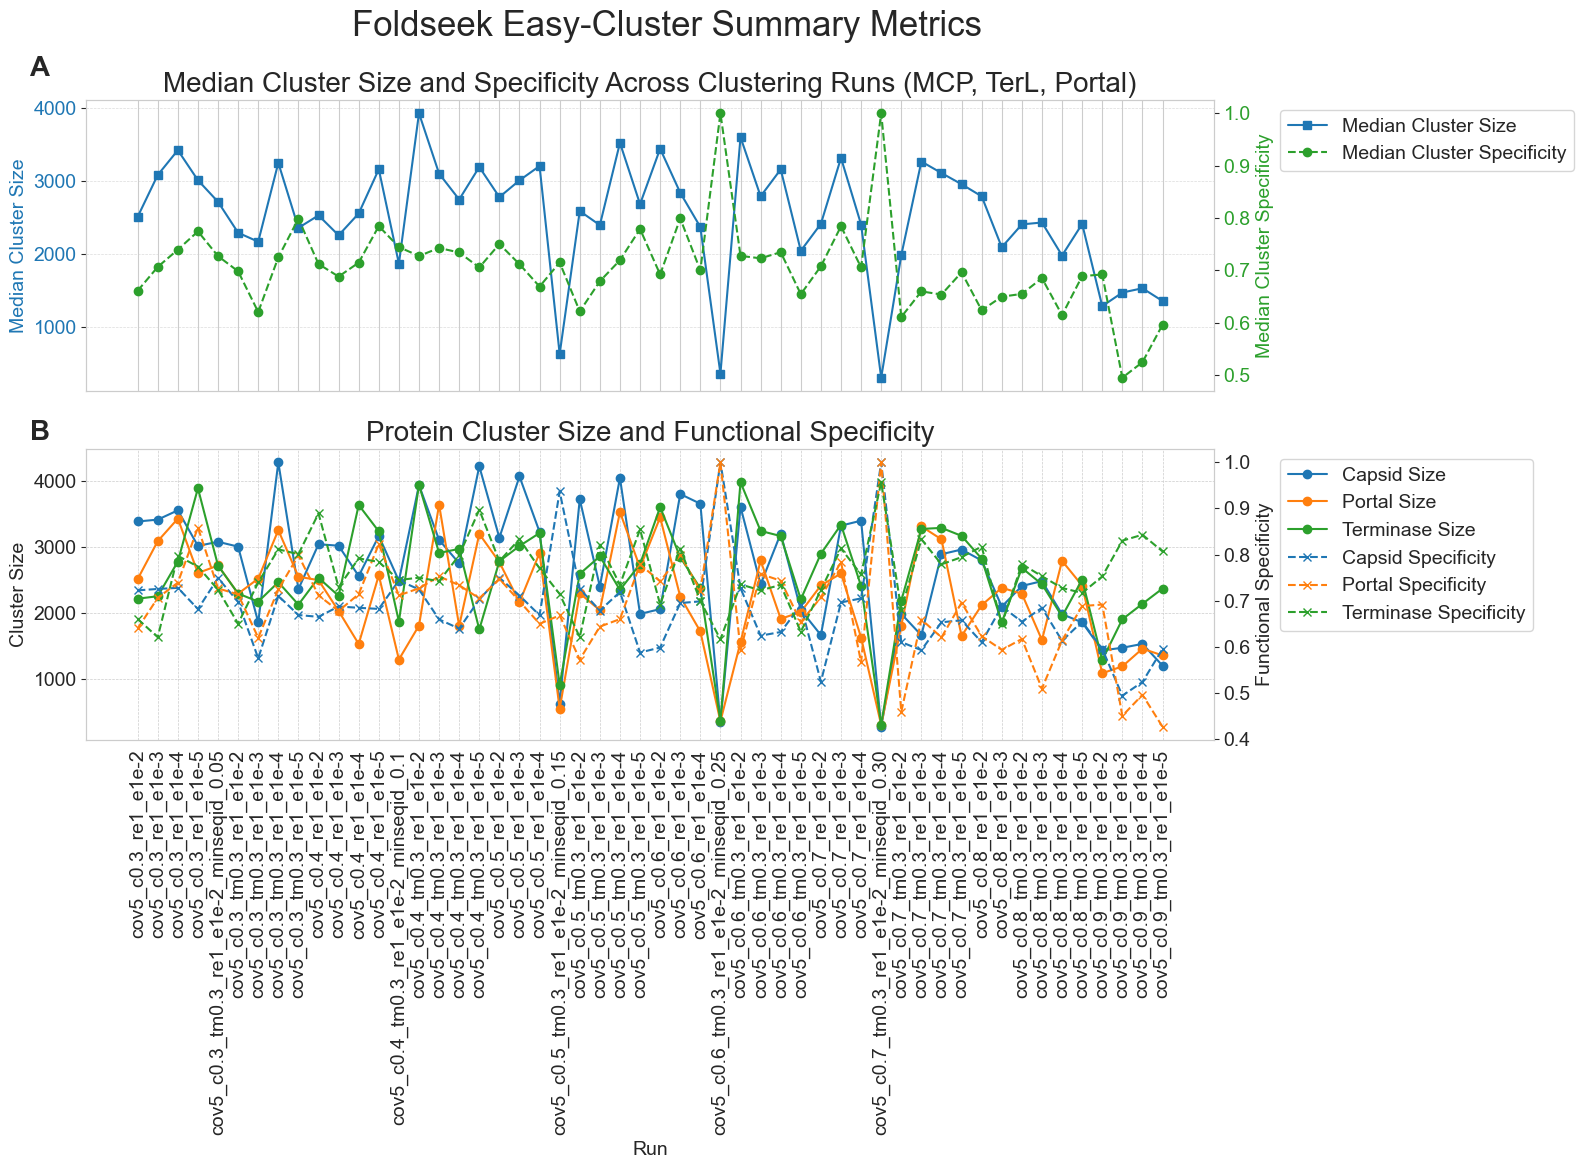

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

markers = ['capsid', 'portal', 'terminase']
colors = {
    'capsid': 'tab:blue',
    'portal': 'tab:orange',
    'terminase': 'tab:green'
}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# --- Top Plot: Median Cluster Size vs. Specificity ---
ax1.plot(summary_df['run'], summary_df['median_cluster_size'], marker='s', color='tab:blue', label='Median Cluster Size')
ax1.set_ylabel("Median Cluster Size", color='tab:blue',fontsize=14)
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
# ax1.axhline(y=2000, color='tab:blue', linestyle=':', linewidth=1.5, alpha=0.7)
ax1.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

ax1b = ax1.twinx()
ax1b.plot(summary_df['run'], summary_df['median_cluster_specificity'], marker='o', color='tab:green', linestyle='--', label='Median Cluster Specificity')
ax1b.set_ylabel("Median Cluster Specificity", color='tab:green',fontsize=14)
ax1b.tick_params(axis='y', labelcolor='tab:green', labelsize=14)
# ax1b.axhline(y=0.75, color='tab:green', linestyle=':', linewidth=1.5, alpha=0.7)
ax1b.grid(False)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1b.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=14)
# Add panel labels
ax1.text(-0.05, 1.15, 'A', transform=ax1.transAxes,
         fontsize=20, fontweight='bold', va='top', ha='left')

ax1.set_title("Median Cluster Size and Specificity Across Clustering Runs (MCP, TerL, Portal)", fontsize=20)

# --- Bottom Plot: Cluster Size and Specificity by Marker ---
for marker in markers:
    ax2.plot(summary_df['run'], summary_df[f"{marker}_size"],
             label=f"{marker.title()} Size", color=colors[marker], marker='o', linestyle='-')

ax2.set_ylabel('Cluster Size',fontsize=14)
ax2.set_xlabel('Run',fontsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(axis='x', labelsize=14)
cleaned_labels = summary_df['run'].str.replace('_cluster_annot', '', regex=False)
ax2.set_xticks(range(len(cleaned_labels)))
ax2.set_xticklabels(cleaned_labels, rotation=90)
ax2.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
ax2.text(-0.05, 1.1, 'B', transform=ax2.transAxes,
         fontsize=20, fontweight='bold', va='top', ha='left')

ax2b = ax2.twinx()
for marker in markers:
    ax2b.plot(summary_df['run'], summary_df[f"{marker}_specificity"],
              label=f"{marker.title()} Specificity", color=colors[marker], marker='x', linestyle='--')

ax2b.set_ylabel('Functional Specificity',fontsize=14)
ax2b.tick_params(axis='y', labelsize=14)
ax2b.grid(False)

lines1b, labels1b = ax2.get_legend_handles_labels()
lines2b, labels2b = ax2b.get_legend_handles_labels()
ax2.legend(lines1b + lines2b, labels1b + labels2b, loc='upper left', bbox_to_anchor=(1.05, 1),fontsize=14)

ax2.set_title("Protein Cluster Size and Functional Specificity", fontsize=20)

# Center the main title
fig.suptitle('Foldseek Easy-Cluster Summary Metrics', fontsize=25, y=0.97, x=0.42)

fig.tight_layout()
plt.subplots_adjust(hspace=0.2)

plt.savefig("../data/plots/combined_cluster_metrics_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# 1.2. Filter high performing runs

## Trade-off between specificity and sensitivity (cluster granularity vs. structural coherence).

1. From this plot, shortlist 5–10 parameter sets with:
   - Median cluster size > 3000
   - Specificity > 0.7  
<br>
<br>

2. For those, calculate:
   - Median RMSD of top N clusters (N = 5 or 10)
   - Median aligned atoms per cluster  
<br>
<br>

3. Select the run with:
   - Highest specificity
   - Lowest RMSD *among those with acceptable cluster size*  

In [36]:
# Candidate runs to calculate PyMOL superposition RMSD:::
sorted(summary_df[
    (summary_df["median_cluster_specificity"] >= 0.70) &
    (summary_df["median_cluster_size"] >= 3000)
]['run'])

['cov5_c0.3_re1_e1e-3_',
 'cov5_c0.3_re1_e1e-4_',
 'cov5_c0.3_re1_e1e-5_',
 'cov5_c0.3_tm0.3_re1_e1e-4_',
 'cov5_c0.4_re1_e1e-5_',
 'cov5_c0.4_tm0.3_re1_e1e-2_',
 'cov5_c0.4_tm0.3_re1_e1e-3_',
 'cov5_c0.4_tm0.3_re1_e1e-5_',
 'cov5_c0.5_re1_e1e-3_',
 'cov5_c0.5_tm0.3_re1_e1e-4_',
 'cov5_c0.6_tm0.3_re1_e1e-2_',
 'cov5_c0.6_tm0.3_re1_e1e-4_',
 'cov5_c0.7_re1_e1e-3_']

In [29]:
# Candidate runs to calculate PyMOL superposition RMSD:::
sorted(summary_df[
    (summary_df["median_cluster_specificity"] >= 0.75) &
    (summary_df["median_cluster_size"] >= 3000)
]['run'])

['cov5_c0.3_re1_e1e-5_', 'cov5_c0.4_re1_e1e-5_', 'cov5_c0.7_re1_e1e-3_']

In [32]:
rmsd_table = pd.DataFrame({
    "RMSD (Å)": ["0–2", "2–4", "4–7", "7–10", ">10"],
    "Interpretation": [
        "Nearly identical (same fold, likely same function)",
        "Similar fold, strong homology",
        "Distantly related, likely same superfamily",
        "Possibly weak or non-homologous; check coverage",
        "Likely not structurally related"
    ],
    "Acceptable?": ["✅ Excellent", "✅ Strong evidence", "✅ Reasonable", "⚠️ Borderline", "❌ Suspicious"]
})

rmsd_table.style.set_caption("RMSD Interpretation Guide").set_table_styles(
    [{"selector": "caption", "props": [("text-align", "left"), ("font-size", "16px"), ("font-weight", "bold")]}]
)

,RMSD (Å),Interpretation,Acceptable?
0,0–2,"Nearly identical (same fold, likely same function)",✅ Excellent
1,2–4,"Similar fold, strong homology",✅ Strong evidence
2,4–7,"Distantly related, likely same superfamily",✅ Reasonable
3,7–10,Possibly weak or non-homologous; check coverage,⚠️ Borderline
4,>10,Likely not structurally related,❌ Suspicious


# 1.3. Import RMSD PyMOL scores:

In [28]:
df = pd.read_csv("../data/foldseek_easy_cluster/candidate_runs_RMSD/top_5_cluster_summaries.tsv", sep="\t")

In [38]:
df.groupby(['parameters'])['median_RMSD'].median()

parameters
cov5_c0.3_re1_e1e-3__cluster_top5_RMSD.tsv                       4.6780
cov5_c0.3_re1_e1e-4__cluster_top5_RMSD.tsv                       4.4400
cov5_c0.3_tm0.3_re1_e1e-4__cluster_top5_RMSD.tsv                 4.4140
cov5_c0.4_tm0.3_re1_e1e-2__cluster_top5_RMSD.tsv                 4.0300
cov5_c0.4_tm0.3_re1_e1e-2_minseqid_0.1_cluster_top5_RMSD.tsv     4.1490
cov5_c0.4_tm0.3_re1_e1e-3__cluster_top5_RMSD.tsv                 4.4595
cov5_c0.4_tm0.3_re1_e1e-5__cluster_top5_RMSD.tsv                 5.2690
cov5_c0.5_re1_e1e-3__cluster_top5_RMSD.tsv                       4.7550
cov5_c0.5_tm0.3_re1_e1e-4__cluster_top5_RMSD.tsv                 5.9290
cov5_c0.6_tm0.3_re1_e1e-2__cluster_top5_RMSD.tsv                 4.6910
cov5_c0.6_tm0.3_re1_e1e-2_minseqid_0.25_cluster_top5_RMSD.tsv    1.5395
cov5_c0.7_re1_e1e-3__cluster_top5_RMSD.tsv                       5.1440
Name: median_RMSD, dtype: float64

In [28]:
# Filter high performing runs..
optimal_runs = summary_df[
    (summary_df["median_cluster_specificity"] >= 0.75) &
    (summary_df["median_cluster_size"] >= 2000)
]['run'].to_list()

In [35]:
optimal_runs

['cov5_c0.3_re1_e1e-5_',
 'cov5_c0.4_tm0.3_re1_e1e-2_minseqid_0.1',
 'cov5_c0.4_tm0.3_re1_e1e-5_',
 'cov5_c0.7_re1_e1e-3_']

In [45]:
# Load data
df = pd.read_csv("../data/foldseek_easy_cluster/candidate_runs_RMSD/top_5_cluster_summaries.tsv", sep="\t")

df['parameters'] = df['parameters'].str.replace('_cluster_top5_RMSD', '')
df['parameters'] = df['parameters'].str.replace('_.tsv', '')
df = df[~df.parameters.str.contains('minseqid_0.25')]

# Sort parameter names
sorted_params = sorted(df['parameters'].unique())
df['parameters'] = pd.Categorical(df['parameters'], categories=sorted_params, ordered=True)

# Assign unique colors per parameter
palette = sns.color_palette("Paired", len(sorted_params))
param_colors = dict(zip(sorted_params, palette))

# Group and compute medians
grouped = df.groupby("parameters", observed=True).agg(
    median_RMSD=("median_RMSD", "median"),
    median_aligned_atoms=("median_aligned_atoms", "median"),
    median_n_members=("n_members", "median")
).reset_index()

In [47]:
grouped['parameters'] = grouped['parameters'].str.replace('.tsv','')
df['parameters'] = df['parameters'].str.replace('.tsv','')

In [48]:
grouped

,parameters,median_RMSD,median_aligned_atoms,median_n_members
0,cov5_c0.3_re1_e1e-3,4.6780,1168.0,3084.0
1,cov5_c0.3_re1_e1e-4,4.4400,1659.0,3262.0
2,cov5_c0.3_tm0.3_re1_e1e-4,4.4140,1660.0,2776.0
3,cov5_c0.4_tm0.3_re1_e1e-2,4.0300,989.0,3367.0
4,cov5_c0.4_tm0.3_re1_e1e-2_minseqid_0.1,4.1490,1072.0,1879.0
5,cov5_c0.4_tm0.3_re1_e1e-3,4.4595,1267.0,3247.0
6,cov5_c0.4_tm0.3_re1_e1e-5,5.2690,1491.0,2761.0
7,cov5_c0.5_re1_e1e-3,4.7550,1399.5,2157.0
8,cov5_c0.5_tm0.3_re1_e1e-4,5.9290,1564.5,2345.0
9,cov5_c0.6_tm0.3_re1_e1e-2,4.6910,1087.0,2137.0


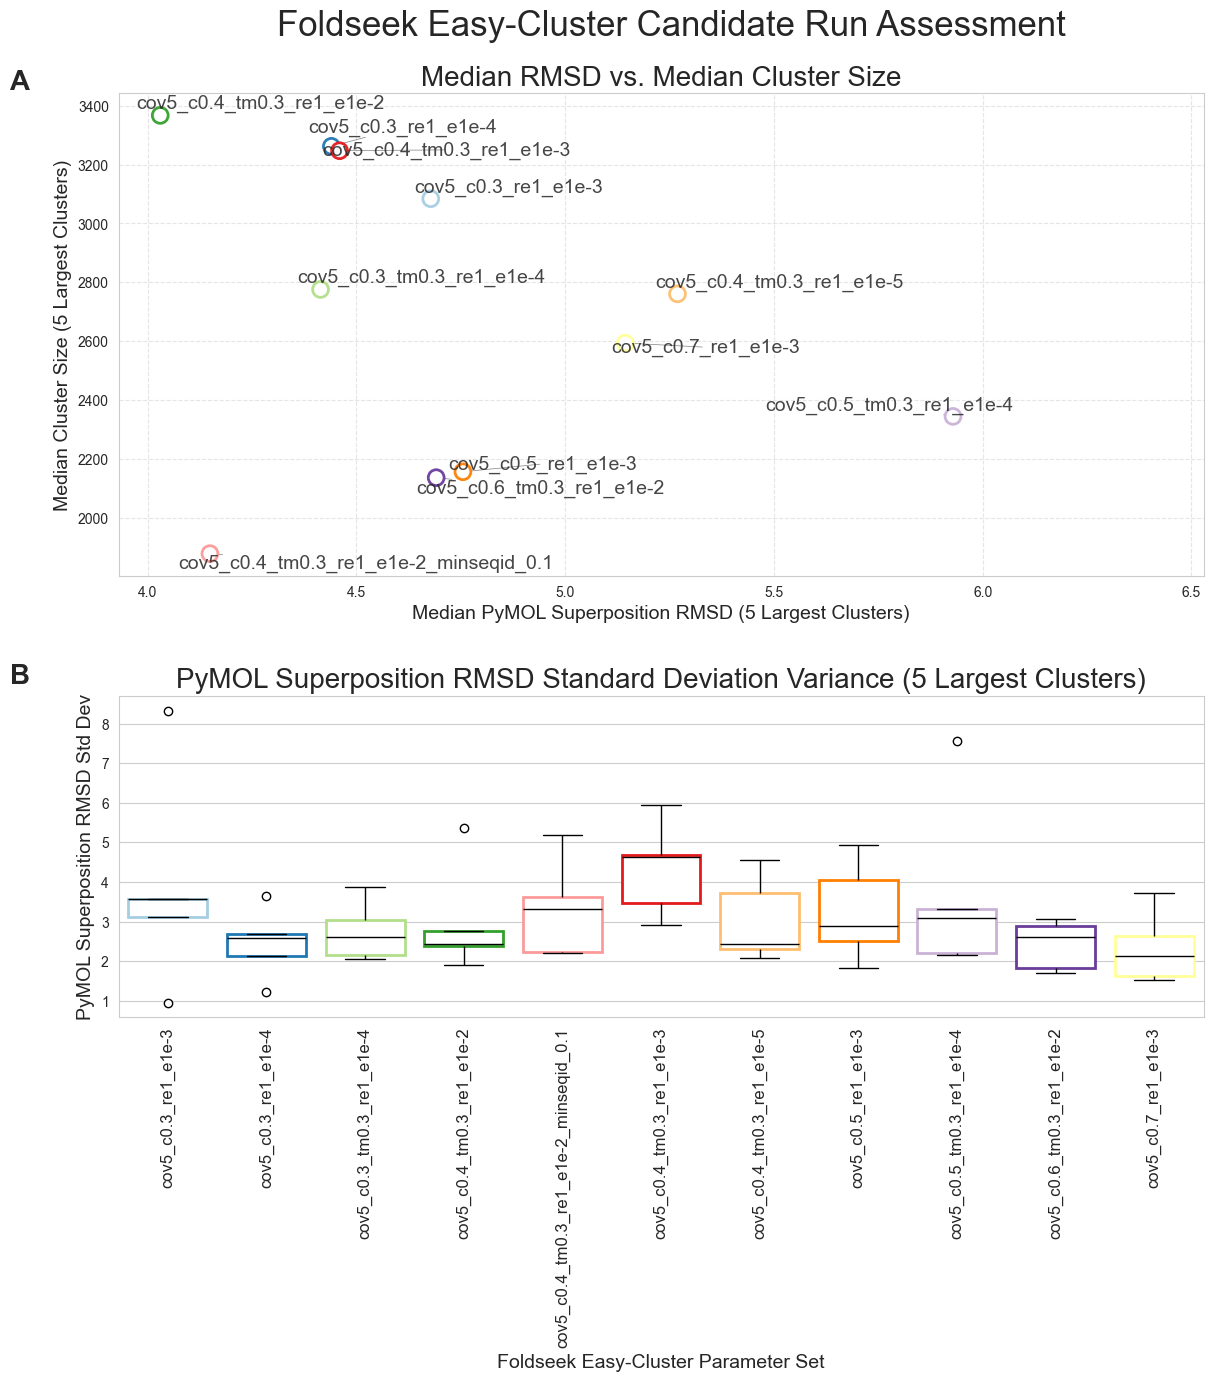

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

# Strip `.tsv` suffix from param_colors keys to match updated 'parameters' values
param_colors = {k.replace('.tsv', ''): v for k, v in param_colors.items()}
sorted_params = [p.replace('.tsv', '') for p in sorted_params]

# --- Plot setup ---
fig, axes = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [1.5, 1]})
# Add "A" and "B" labels to the subplots
axes[0].text(-0.1, 1.05, "A", transform=axes[0].transAxes,
             fontsize=20, fontweight='bold', va='top', ha='left')
axes[1].text(-0.1, 1.10, "B", transform=axes[1].transAxes,
             fontsize=20, fontweight='bold', va='top', ha='left')
plt.subplots_adjust(hspace=0.3)

# --- Plot 1: Scatter with RMSD fill + unique outline colors ---
sc = axes[0].scatter(
    grouped['median_RMSD'],
    grouped['median_n_members'],
    color='white',
    s=130,
    edgecolors=[param_colors[param] for param in grouped['parameters']],
    linewidths=2,
    alpha=0.95,
    zorder=3
)

# Collect label objects
texts = []
for _, row in grouped.iterrows():
    texts.append(
        axes[0].text(
            row['median_RMSD'],
            row['median_n_members'],
            row['parameters'],
            fontsize=14,
            alpha=0.85
        )
    )

# Adjust labels to avoid overlap
adjust_text(texts, ax=axes[0], arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))

axes[0].set_xlim(grouped['median_RMSD'].min() - 0.1, grouped['median_RMSD'].max() + 0.6)
axes[0].set_xlabel("Median PyMOL Superposition RMSD (5 Largest Clusters)", fontsize=14)
axes[0].set_ylabel("Median Cluster Size (5 Largest Clusters)", fontsize=14)
axes[0].set_title("Median RMSD vs. Median Cluster Size", fontsize=20)
axes[0].grid(True, linestyle="--", alpha=0.5)

# --- Plot 2: Boxplot with whitegrid background ---
sns.set_style("whitegrid")

sns.boxplot(
    data=df,
    x="parameters",
    y="std_RMSD",
    order=sorted_params,
    ax=axes[1],
    boxprops=dict(facecolor='white', edgecolor='black'),
    medianprops=dict(color='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    flierprops=dict(markerfacecolor='white', markeredgecolor='black')
)

# Set colored outlines per box
for patch, param in zip(axes[1].patches, sorted_params):
    color = param_colors[param]
    patch.set_edgecolor(color)
    patch.set_linewidth(2)

axes[1].set_xlabel("Foldseek Easy-Cluster Parameter Set", fontsize=14)
axes[1].set_ylabel("PyMOL Superposition RMSD Std Dev", fontsize=14)
axes[1].set_title("PyMOL Superposition RMSD Standard Deviation Variance (5 Largest Clusters)", fontsize=20)
axes[1].tick_params(axis='x', rotation=90, labelsize=12)

fig.suptitle("Foldseek Easy-Cluster Candidate Run Assessment", fontsize=25, y=0.95, x=0.52)

plt.savefig("../data/plots/foldseek_easy_cluster_parameter_sets_pymol_superposition_RMSD.png", dpi=300, bbox_inches='tight')
plt.show()

# Choosing cov5_c0.4_tm0.3_re1_e1e-2 parameters as optimal run 
### Largest median cluster size, lowest superposition RMSD (\~4.0) and compact pymol superposition RMSD std dev (~2.75)

In [48]:
clu_grpd = group_clusters_taxonomy(annotated_dfs['cov5_c0.4_tm0.3_re1_e1e-2__cluster_annot'], ictv_metadata)

In [52]:
group_clusters_taxonomy(annotated_dfs['cov5_c0.4_tm0.3_re1_e1e-2__cluster_annot'], ictv_metadata)[0:10]

,cluster,unique_genome_count,cluster_function,cluster_PFAM1_definition,member_PFAM1_definition,unique_family_count
0,YP_009620569.1,3820,terminase large subunit,Terminase RNaseH-like domain,Phage terminase large subunit,65
1,YP_010082820.1,3510,hypothetical protein KMD24_gp018,Phage major capsid protein E,Phage capsid family,68
2,YP_008058468.1,2355,tail tube protein,Phage tail tube protein,Phage tail tube protein,46
3,YP_010063459.1,2059,tail terminator,Protein of unknown function (DUF3168),Phage minor tail protein U,41
4,YP_009595775.1,2003,hypothetical protein FDH00_gp17,Phage minor tail protein L,Phage head-tail joining protein,33
5,YP_009802963.1,1803,portal protein,RC Paper describing PDB structure 2jes ...,RC Paper describing PDB structure 2jes ...,43
6,YP_009824164.1,1417,DNA primase/helicase,DnaB-like helicase C terminal domain,DnaB-like helicase N terminal domain,30
7,YP_009963153.1,1381,anaerobic ribonucleoside reductase large subunit,Terminase RNaseH-like domain,Helicase C-terminal domain,27
8,YP_009855449.1,1327,DNA polymerase,Exonuclease C-terminal,DNA polymerase family A,30
9,YP_009189634.1,1247,recombination endonuclease subunit,Calcineurin-like phosphoesterase,Calcineurin-like phosphoesterase,35


# 2. Visualize foldseek alignments and pLDDT score distribution

In [51]:
# generates table of top 10 most populous clusters by unique number of phage genomes and the number of unique families represented in each
clu_c40_tm30_re1_e1e_2 = group_clusters_taxonomy(annotated_dfs['cov5_c0.4_tm0.3_re1_e1e-2__cluster_annot'], ictv_metadata)[0:10]

# filters all annotated cluster dfs to contain plddt scores for all top 10 clusters and their members
clu_c40_tm30_re1_e1e_2_clusters_plddts = annotated_dfs['cov5_c0.4_tm0.3_re1_e1e-2__cluster_annot'][annotated_dfs['cov5_c0.4_tm0.3_re1_e1e-2__cluster_annot'].cluster.isin\
(group_clusters_taxonomy(annotated_dfs['cov5_c0.4_tm0.3_re1_e1e-2__cluster_annot'], ictv_metadata)[0:10]['cluster'].to_list())]

In [53]:
clu_c40_tm30_re1_e1e_2_clusters_plddts = clu_c40_tm30_re1_e1e_2_clusters_plddts[
    clu_c40_tm30_re1_e1e_2_clusters_plddts.member_pLDDT.notna() & 
    clu_c40_tm30_re1_e1e_2_clusters_plddts.cluster_pLDDT.notna()
]

In [50]:
def filter_top_clusters_with_plddt(annot_df, metadata_df, top_n=10):
    """
    Filters an annotated cluster DataFrame to include only the top N clusters
    with member and cluster pLDDT scores available.

    Parameters:
        annot_df (pd.DataFrame): Annotated cluster dataframe (with 'cluster', 'member_pLDDT', 'cluster_pLDDT' columns).
        metadata_df (pd.DataFrame): ICTV metadata used by `group_clusters_taxonomy()`.
        top_n (int): Number of top clusters to retain.

    Returns:
        pd.DataFrame: Filtered DataFrame with only clusters in top N and non-null pLDDT scores.
    """
    top_10_clusters = group_clusters_taxonomy(annot_df, metadata_df).iloc[:top_n]
    top_clusters = group_clusters_taxonomy(annot_df, metadata_df).iloc[:top_n]['cluster'].to_list()
    filtered = annot_df[
        annot_df.cluster.isin(top_clusters) &
        annot_df.member_pLDDT.notna() &
        annot_df.cluster_pLDDT.notna()
    ]
    return top_10_clusters, filtered

In [49]:
# Custom color palette for pLDDT scores
def color_palette(pLDDT):
    if pLDDT < 70:
        return sns.color_palette("Reds", n_colors=10)[int(9 * (pLDDT / 70))]  # Scale color from red
    else:
        return sns.color_palette("Blues", n_colors=10)[int(9 * ((pLDDT - 70) / 30))]  # Scale color from blue

def plot_cluster_member_plddts_barplots(df_plddts, df_counts, title='Cluster and Member pLDDT Scores', filename='cluster_member_plddts_plot.png'):
    sns.set_theme(style='whitegrid')
    df = df_plddts.copy()  # Avoid modifying the original DataFrame
    df['color'] = df['member_pLDDT'].apply(color_palette)
    df = clean_definitions(df)
    df_counts = clean_definitions(df_counts)
    cluster_id_mapping = df.drop_duplicates(subset=['cluster', 'cluster_ID']).set_index('cluster')['cluster_ID'].to_dict()
    df_counts['cluster_ID'] = df_counts['cluster'].map(cluster_id_mapping).combine_first(df_counts['cluster_ID'])

    cluster_member_counts = df.cluster_ID.value_counts()

    # Get unique values and sort them
    original_arr = df['cluster_pLDDT'].unique()
    sorted_arr = np.sort(original_arr)
    adjusted_y_ticks = sorted_arr.copy()

    # Adjust y-ticks to ensure no overlapping y-axis labels
    for i in range(1, len(adjusted_y_ticks)):
        if (adjusted_y_ticks[i] - adjusted_y_ticks[i - 1]) < 1:
            adjusted_y_ticks[i] = adjusted_y_ticks[i - 1] + 1
            # Find the index of the adjusted value in the original array
            original_index = np.where(original_arr == sorted_arr[i])[0][0]
            original_arr[original_index] = adjusted_y_ticks[i]
    
    # Create a mapping from the original values to the adjusted values
    value_mapping = dict(zip(sorted_arr, adjusted_y_ticks))
    
    # Update the DataFrame with the adjusted values
    df['cluster_pLDDT'] = df['cluster_pLDDT'].replace(value_mapping)

    y_tick_labels = [
        textwrap.fill(f'ID: {cluster} (pLDDT: {sorted_arr[i]:.2f})', width=80)  # Adjust width to avoid mid-word breaks
        for i, cluster in enumerate(df['cluster_ID'].unique())
    ]

    # Create figure with two rows: one full-width barplot on top and two side-by-side subplots below
    fig = plt.figure(figsize=(11, 11))
    fig.suptitle(title, fontsize=26, x=0.5, y=0.99, ha='center')
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

    ax1 = fig.add_subplot(gs[0, :])
    # Scatter plot of member pLDDT vs. cluster pLDDT
    sns.scatterplot(data=df, x='member_pLDDT', y='cluster_pLDDT', color=df['color'], s=100, ax=ax1)
    ax1.set_title('Cluster and Member pLDDT Scores')
    ax1.set_xlabel('Member pLDDT')
    ax1.set_ylabel('Cluster pLDDT')

    if len(adjusted_y_ticks) == len(y_tick_labels):
        ax1.set_yticks(adjusted_y_ticks)
        ax1.set_yticklabels(y_tick_labels)
    
    # Annotate the number of members at the end of each cluster
    for cluster, y_pos in zip(df['cluster_ID'].unique(), adjusted_y_ticks):
        member_count = cluster_member_counts[cluster]
        ax1.text(99, y_pos, f'Proteins: {member_count}', 
                 verticalalignment='center', fontsize=9, color='black')

    ###############################################

    ax2 = fig.add_subplot(gs[1, 0])
    # Plot 2: Bar plot for unique viral genomes per PFAM definition (Top 10)
    sns.barplot(x='unique_genome_count', y='cluster_ID', data=df_counts, hue='cluster_ID', palette="Blues_r", ax=ax2, legend=False)
    ax2.set_title('Unique Viral Genomes per Cluster', x=0.3)
    ax2.set_xlabel('Viral Genomes Count')
    ax2.set_ylabel('Cluster ID')
    
    # Annotate the number of genomes on each bar in ax2
    for i, count in enumerate(df_counts['unique_genome_count']):
        ax2.text(count + 0.1, i, str(count), va='center')

    ax3 = fig.add_subplot(gs[1, 1])
    ax3.sharey(ax2)  # Ensure ax3 shares the y-axis with ax2
    
    # Plot 3: Bar plot for unique families per PFAM definition
    palette_families = sns.color_palette("Greens", n_colors=df_counts['cluster_ID'].nunique())[::-1]
    sns.barplot(x='unique_family_count', y='cluster_ID', data=df_counts, hue='cluster_ID', palette=palette_families, ax=ax3, legend=False)
    ax3.set_title('Unique Families (ICTV VMR38) per Cluster',x=0.9)
    ax3.set_xlabel('Unique Families Count')
    ax3.set_ylabel('')
    ax3.get_yaxis().set_visible(False)
    
    # Annotate the number of families on each bar in ax3
    for i, count in enumerate(df_counts['unique_family_count']):
        ax3.text(count + 0.1, i, str(count), va='center')
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.savefig(filename, dpi=600, bbox_inches='tight', format='png')
    plt.show()

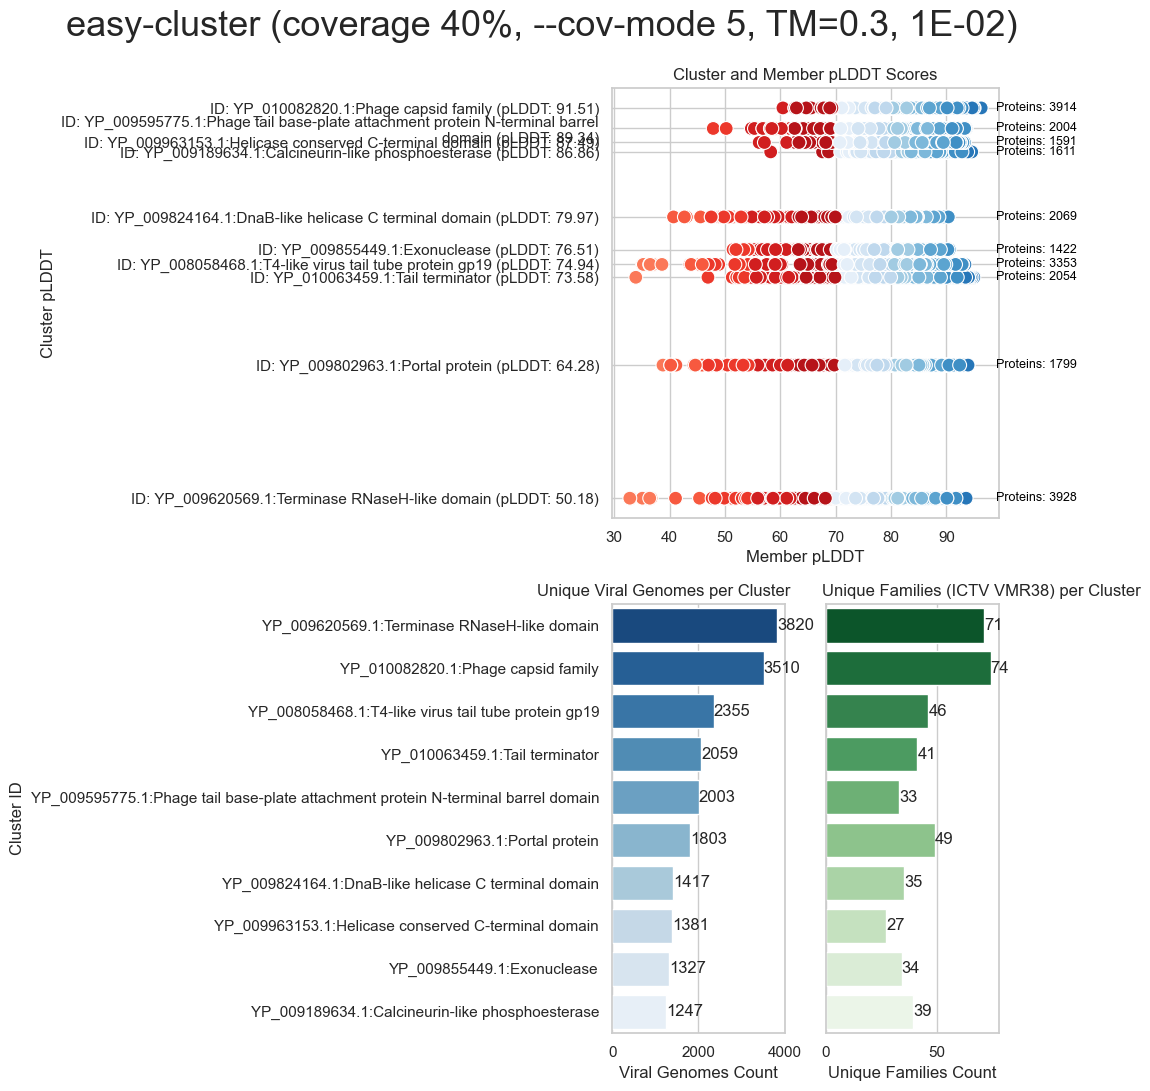

In [55]:
plot_cluster_member_plddts_barplots(clu_c40_tm30_re1_e1e_2_clusters_plddts, clu_c40_tm30_re1_e1e_2,
                                   title='easy-cluster (coverage 40%, --cov-mode 5, TM=0.3, 1E-02)',
                                    filename='cluster_member_plddts_plot_test_1.png')

# 2.1. Take distribution of proteins with varying pLDDTs from largest clusters and visualize them using foldseek alignment html tool

In [60]:
df = annotated_dfs['cov5_c0.4_tm0.3_re1_e1e-2__cluster_annot']

In [61]:
clu_c40_tm30_re1_e1e_2[0:3]

,cluster,unique_genome_count,cluster_function,cluster_PFAM1_definition,member_PFAM1_definition,unique_family_count
0,YP_009620569.1,3820,terminase large subunit,Terminase RNaseH-like domain,Phage terminase large subunit,71
1,YP_010082820.1,3510,hypothetical protein KMD24_gp018,Phage major capsid protein E,Phage capsid family,74
2,YP_008058468.1,2355,tail tube protein,Phage tail tube protein,Phage tail tube protein,46


In [64]:
YP_009620569_TerL = df[df.cluster=='YP_009620569.1']

In [65]:
YP_010082820_MCP = df[df.cluster=='YP_010082820.1']

In [66]:
YP_009195687_tail_tube = df[df.cluster=='YP_008058468.1']

In [70]:
def get_plddt_dist(df):
    # Define the range for filtering
    min_value = df['member_pLDDT'].min()
    max_value = df['member_pLDDT'].max()
    
    # Generate 10 evenly spaced values within the range
    quantiles = np.linspace(min_value, max_value, num=10)
    
    # Sample closest values to quantiles
    sampled_indices = []
    for q in quantiles:
        closest_idx = (df['member_pLDDT'] - q).abs().idxmin()  # Find closest index
        if closest_idx not in sampled_indices:  # Avoid duplicates
            sampled_indices.append(closest_idx)
    
    # Retrieve sampled rows
    sampled_df = df.loc[sampled_indices]
    return sampled_df

In [71]:
terl_sample = get_plddt_dist(YP_009620569_TerL)
mcp_sample = get_plddt_dist(YP_010082820_MCP)
tail_tube_sample = get_plddt_dist(YP_009195687_tail_tube)

In [73]:
def melt_with_metadata(df, protein_label="MCP"):
    # Get cluster data
    cluster_df = df[["cluster", "cluster_function", "cluster_pLDDT"]].copy()
    cluster_df.columns = ["protein_accn", "function", "plddt"]
    cluster_df["cluster_member"] = "cluster"
    
    # Get member data
    member_df = df[["members", "member_function", "member_pLDDT"]].copy()
    member_df.columns = ["protein_accn", "function", "plddt"]
    member_df["cluster_member"] = "member"
    
    # Combine
    melted = pd.concat([cluster_df, member_df], ignore_index=True)
    
    # Optionally: remove duplicates
    melted = melted.drop_duplicates(subset="protein_accn")
    
    # Fill in the source label (e.g., MCP, TerL, Portal)
    melted["source"] = protein_label
    
    return melted[["protein_accn", "function", "plddt", "cluster_member", "source"]]

In [ ]:
terl_sample = get_plddt_dist(YP_009620569_TerL)
mcp_sample = get_plddt_dist(YP_010082820_MCP)
tail_tube_sample = get_plddt_dist(YP_009195687_tail_tube)

In [74]:
terl_melted = melt_with_metadata(terl_sample, protein_label="TerL")
mcp_melted = melt_with_metadata(mcp_sample, protein_label="MCP")
tail_tube_melted = melt_with_metadata(tail_tube_sample, protein_label="Tail_tube")

In [76]:
combined = pd.concat([mcp_melted, terl_melted, tail_tube_melted], ignore_index=True)

In [77]:
combined.to_csv('../data/cluster_plddt_score_alignment_distribution.csv',index=False)

Pass this csv into script: extract_plddt_dist_proteins.py which pulls out the pdbs for each cluster - then run:
* foldseek easy-search MCP/ MCP/ MCP_result.html tmp --format-mode 3
* html alignment files are in /data/foldseek_easy_search/*.html

# 3. Select most conserved proteins to visualize in PyMOL (Figure 1)

In [79]:
#df = annotated_dfs['cov5_c0.4_tm0.3_re1_e1e-2__cluster_annot']
df = pd.read_csv('../data/foldseek_easy_cluster/test_thresholds/cov5_c0.4_tm0.3_re1_e1e-2__cluster.tsv',sep='\t',header=None)

In [80]:
clu_annot = annotate_clusters(df, metadata)

In [81]:
clu_grpd = group_clusters_taxonomy_orders(clu_annot, ictv_metadata)

In [47]:
mcp_keywords = (
    'major head|capsid|head'
)

mcp_candidates = clu_grpd[
    clu_grpd['cluster_PFAM1_definition'].str.contains(mcp_keywords, case=False, na=False) |
    clu_grpd['member_PFAM1_definition'].str.contains(mcp_keywords, case=False, na=False)
]

#orders_of_interest = ['Crassvirales', 'Autographivirales', 'Grandevirales']
orders_of_interest = ['Crassvirales']

order_filtered = mcp_candidates[
    mcp_candidates['unique_orders'].apply(lambda x: any(order in x for order in orders_of_interest))
]

In [181]:
tail_keywords = (
    'tail terminator|tail completion|minor tail|tail collar|gpU|GpU|Gp7|' 
    'gp15|Gp15|gp19|tail shaft termination'
)

tail_keywords = (
    'tail'
)

tail_candidates = clu_grpd[
    clu_grpd['cluster_PFAM1_definition'].str.contains(tail_keywords, case=False, na=False) |
    clu_grpd['member_PFAM1_definition'].str.contains(tail_keywords, case=False, na=False)
]


orders_of_interest = ['Crassvirales', 'Autographivirales', 'Grandevirales']

order_filtered = tail_candidates[
    tail_candidates['unique_orders'].apply(lambda x: any(order in x for order in orders_of_interest))
]

In [143]:
primase_helicase_keywords = (
    'primase|helicase|DnaB|DnaG|replicative helicase|'
    'zinc-binding helicase|ATP-dependent helicase|Origin of replication'
)
primase_helicase_candidates = clu_grpd[
    clu_grpd['cluster_PFAM1_definition'].str.contains(primase_helicase_keywords, case=False, na=False) |
    clu_grpd['member_PFAM1_definition'].str.contains(primase_helicase_keywords, case=False, na=False)
]

In [174]:
keywords = 'helicase|primase|DnaB|DnaG|SF1|SF2|ATPase|helic|unwinding|replicative|replication protein|MCM|NTPase'
keywords = 'tail'


filtered = clu_grpd[
    clu_grpd['cluster_function'].str.contains(keywords, case=False, na=False) |
    clu_grpd['cluster_PFAM1_definition'].str.contains(keywords, case=False, na=False) |
    clu_grpd['member_PFAM1_definition'].str.contains(keywords, case=False, na=False)
]


# Now filter for rows where 'Kirjokansivirales' is in the list of unique_orders
kirjo_filtered = filtered[
    filtered['unique_orders'].apply(lambda orders: 'Crassvirales' in orders)
]

kirjo_filtered.head(25)

,cluster,unique_genome_count,cluster_function,cluster_PFAM1_definition,member_PFAM1_definition,unique_orders
31,YP_009850039.1,760,tail protein,Head binding,Collagen triple helix repeat (20 copies),"[Unclassified_Family, Pantevenvirales, Juravir..."
43,YP_214447.1,614,L-shaped tail fiber protein assembly,Major spike protein (G protein),Restriction endonuclease BglI,"[Methanobavirales, Unclassified_Family, Juravi..."
49,YP_010052677.1,588,tail fiber protein,Head binding,Collagen triple helix repeat (20 copies),"[Unclassified_Family, Pantevenvirales, Autogra..."
56,YP_009822271.1,544,tail fiber protein,Beta barrel domain of bacteriophage endosialidase,gp58-like protein,"[Autographivirales, Unclassified_Family, Pante..."
66,YP_009098374.1,453,tail protein,Tail tubular protein,Tail tubular protein,"[Autographivirales, Unclassified_Family, Grand..."
98,YP_009594367.1,353,tail spike protein,Chaperone of endosialidase,S-layer homology domain,"[Unclassified_Family, Pantevenvirales, Autogra..."
105,YP_009815579.1,334,tail protein,Right handed beta helix region,Pectate lyase superfamily protein,"[Unclassified_Family, Autographivirales, Pante..."
153,YP_007005675.1,239,hypothetical protein F419_gp14,Protein of unknown function (DUF3199),Tail tubular protein,"[Unclassified_Family, Crassvirales]"
173,YP_009103358.1,216,tail fiber protein,BURP domain,Cellulose binding domain,"[Methanobavirales, Unclassified_Family, Juravi..."
224,YP_010089519.1,182,baseplate hub,"Baseplate structural protein, domain 1",Phage tail base-plate attachment protein N-ter...,"[Unclassified_Family, Pantevenvirales, Nakonvi..."


In [118]:
# being liberal with pfam annotation definitions to fish out all possible homologous proteins
keywords = (
    'polymerase|'                    # general
    'DNA polymerase|'                # full term
    'Pol I|PolI|'                    # DNA polymerase I
    'Pol II|PolII|'                  # DNA polymerase II
    'Pol III|PolIII|'                # DNA polymerase III
    'Pol IV|PolIV|Pol V|PolV|'       # error-prone polymerases
    'PolA|PolB|PolC|'                # standard polymerase gene symbols
    'DNAP|'                          # abbreviation
    'DNA Pol|'                       # abbreviated term
    'family A DNA polymerase|'       # specific types
    'family B DNA polymerase|PolB|Pol b|Pol-b|PolB-like|polymerase B|'  # viral/archaeal
    'DNA-directed DNA polymerase|'   # verbose annotation
    'replicase|'                     # common synonym in viral contexts
    'reverse transcriptase|'         # RNA→DNA polymerase
    'RdDP|'                          # RNA-dependent DNA polymerase
    'terminal protein-primed DNA polymerase'  # phage-specific class
)

filtered = clu_grpd[
    clu_grpd['cluster_PFAM1_definition'].str.contains(keywords, case=False, na=False)
]

# Now filter for rows where 'Methanobavirales' is in the list of unique_orders
Methano_filtered = filtered[
    filtered['unique_orders'].apply(lambda orders: 'Methanobavirales' in orders)
]

# Show top 25
Methano_filtered.head(25)

,cluster,unique_genome_count,cluster_function,cluster_PFAM1_definition,member_PFAM1_definition,unique_orders
55,YP_004957006.1,545,DNA polymerase processivity factor,DNA polymerase processivity factor,Proliferating cell nuclear antigen C-terminal ...,"[Methanobavirales, Pantevenvirales, Unclassifi..."
25742,DBA35390.1,1,TPA_asm: hypothetical protein vir080_00017,Gp68-like predicted RNA polymerase component,Protein of unknown function DUF,[Methanobavirales]


In [83]:
prots_to_viz = [
    # terminases
    "YP_009620569.1",
    "YP_009783023.1",
    #MCP
    "YP_010082820.1",
    "YP_008240652.1",
    #tail tube
    "YP_008058468.1",
    "YP_009302436.1",
    "YP_009098374.1",
    # tail terminator
    "YP_010063459.1",
    "YP_003347506.1",
    "YP_009147612.1",
    "YP_009788782.1",
    #portal    
    "YP_009802963.1",
    "YP_009908791.1",
    "YP_009807042.1"#,
    # #dna polymerase
    # "YP_009855449.1",
    # "YP_010062267.1",
    # "WAE39438.1",
    # "YP_010056684.1"
]

In [84]:
clu_annot["cluster"] = clu_annot["cluster"].astype(str).str.strip()
clu_annot["members"] = clu_annot["members"].astype(str).str.strip()

clusters_to_viz = clu_annot[
    clu_annot["cluster"].isin(prots_to_viz) |
    clu_annot["members"].isin(prots_to_viz)
]

In [85]:
ictv_metadata_family = ictv_metadata[['genome_accn', 'Family']]
ictv_metadata_order = ictv_metadata[['genome_accn', 'Order']]

# 3.1 Normalize structural cluster count by % genomes per order that have it..

In [86]:
# Add Order info to each genome in the cluster df
df = clusters_to_viz.merge(ictv_metadata_order[['genome_accn', 'Order']], 
                           left_on='member_genome_accn', 
                           right_on='genome_accn', 
                           how='left')

df['Order'] = df['Order'].fillna('Unclassified_Order')

# Total # of genomes per Order (denominator)
order_totals = ictv_metadata_order.copy()
order_totals['Order'] = order_totals['Order'].fillna('Unclassified_Order')
total_genomes_per_order = order_totals.groupby('Order')['genome_accn'].nunique().to_dict()

# For each cluster, count unique genomes per Order
cluster_order_counts = (
    df.groupby(['cluster', 'Order'])['member_genome_accn']
    .nunique()
    .reset_index(name='genomes_with_cluster')
)

# Add total genomes per Order & compute %
cluster_order_counts['total_genomes_in_order'] = cluster_order_counts['Order'].map(total_genomes_per_order)
cluster_order_counts['percent'] = cluster_order_counts['genomes_with_cluster'] / cluster_order_counts['total_genomes_in_order']

# Create a label map from unique clusters
cluster_label_map = (
    df[['cluster', 'cluster_PFAM1_definition']]
    .drop_duplicates(subset='cluster')
    .set_index('cluster')['cluster_PFAM1_definition']
    .astype(str)
    .map(lambda s: s if pd.notna(s) else "Unknown")
    + ' | ' + df[['cluster']].drop_duplicates()['cluster'].astype(str).values
)

cluster_order_counts['cluster_label'] = cluster_order_counts['cluster'].map(cluster_label_map)

pivot_df = cluster_order_counts.pivot(index='cluster_label', columns='Order', values='percent').fillna(0)

pivot_df[0:2]

Order,Adrikavirales,Autographivirales,Crassvirales,Grandevirales,Juravirales,Kirjokansivirales,Magrovirales,Methanobavirales,Nakonvirales,Pantevenvirales,Thumleimavirales,Unclassified_Order
cluster_label,,,,,,,,,,,,
Phage Connector (GP10) | YP_009908791.1,0.0,0.538462,0.082192,0.0,0.25,0.285714,0.333333,0.571429,0.0,0.207715,0.714286,0.283197
Phage major capsid protein E | YP_010082820.1,1.0,0.973373,0.013699,1.0,0.50,0.857143,0.666667,1.000000,1.0,0.988131,1.000000,0.853236


In [21]:
replacements = [
    (r'^RC\s+Paper\s+describing\s+PDB.*?Phage portal protein, SPP1 Gp6-like', 'Phage portal protein, SPP1 Gp6-like:')
]

for pattern, replacement in replacements:
    pivot_df.index = pivot_df.index.str.replace(pattern, replacement, regex=True)
pivot_df.index = pivot_df.index.str.replace(r'::', ':', regex=True)

In [56]:
pivot_df = pivot_df.rename(index={
    "Protein of unknown function (DUF3168) | YP_003347506.1": 
    "Tail terminator (DUF3168) | YP_003347506.1",
    "Protein of unknown function (DUF3168) | YP_010063459.1":
    "Tail terminator (DUF3168) | YP_010063459.1",
    "Reovirus major virion structural protein Mu-1/Mu-1C (M2) | YP_008240652.1":
    "Major virion structural protein Mu-1/Mu-1C (M2) | YP_008240652.1"
})

In [22]:
pivot_df.index

Index(['Phage Connector (GP10) | YP_009908791.1',
       'Phage major capsid protein E | YP_010082820.1',
       'Phage portal protein | YP_009807042.1',
       'Phage tail tube protein | YP_008058468.1',
       'Phage tail tube protein | YP_009302436.1',
       'Protein of unknown function (DUF3168) | YP_003347506.1',
       'Protein of unknown function (DUF3168) | YP_010063459.1',
       'Phage portal protein, SPP1 Gp6-like: | YP_009802963.1',
       'Reovirus major virion structural protein Mu-1/Mu-1C (M2) | YP_008240652.1',
       'T4-like virus tail tube protein gp19 | YP_009147612.1',
       'Tail tubular protein | YP_009098374.1',
       'Terminase RNaseH-like domain | YP_009620569.1',
       'Terminase RNaseH-like domain | YP_009783023.1'],
      dtype='object', name='cluster_label')

In [87]:
pivot_df.to_csv('../data/most_conserved_clusters_by_order_percentage.csv')

# 4. Total folded proteins per genome

In [62]:
clu_annot = annotated_dfs['cov5_c0.4_tm0.3_re1_e1e-2__cluster_annot']

In [63]:
genome_metadata = pd.read_csv('../data/genome_ncbi_metadata_with_taxonomy.csv')

In [64]:
# 1: Get unique protein accessions for each genome
unique_proteins_per_genome = clu_annot.groupby('member_genome_accn')['members'].unique().reset_index()
unique_proteins_per_genome.columns = ['genome_accn', 'unique_members_proteins_list']

# 2: Count unique genomes per cluster (cluster_genome_accn)
unique_genomes_per_cluster = clu_annot.groupby('cluster_genome_accn')['cluster'].unique().reset_index()
unique_genomes_per_cluster.columns = ['genome_accn', 'unique_cluster_proteins_list']

In [65]:
combined_results = pd.merge(unique_proteins_per_genome, unique_genomes_per_cluster, on='genome_accn', how='outer')

In [66]:
# Function to combine lists while excluding NaN values
def combine_lists(row):
    # Ensure that we are working with lists
    if isinstance(row['unique_members_proteins_list'], list) and pd.notna(row['unique_members_proteins_list']):
        return row['unique_members_proteins_list'] + row['unique_cluster_proteins_list']
    else:
        return row['unique_members_proteins_list']  # Return just the unique_proteins_list if 'unique_genomes_count' is NaN or not a list

combined_results['combined_list'] = combined_results.apply(combine_lists, axis=1)

total_prots_per_genome= combined_results[['genome_accn','combined_list']].explode(column='combined_list',ignore_index=True)

In [68]:
total_prots_per_genome = total_prots_per_genome.groupby(['genome_accn'])['combined_list'].count()

In [71]:
total_prots_per_genome = total_prots_per_genome.reset_index().rename(columns={'combined_list':'proteins_folded'})

In [72]:
# Strip version suffix from genome accession (e.g., 'NC_188372.1' -> 'NC_188372')
total_prots_per_genome['genome_accn'] = total_prots_per_genome['genome_accn'].str.split('.').str[0]
genome_metadata['genome_accn'] = genome_metadata['genome_accn'].str.split('.').str[0]

total_prots_per_genome = total_prots_per_genome.merge(
    genome_metadata,
    on='genome_accn'
).sort_values(by='genome_accn')

In [74]:
total_prots_per_genome[0:2]

,genome_accn,proteins_folded,genome_name,genome_length,total_proteins,taxonomy_string
0,BK063677,30,TPA_asm: Caudoviricetes sp. vir080 genomic seq...,53200,72,Viruses; Duplodnaviria; Heunggongvirae; Urovir...
1,BK063678,24,TPA_asm: Caudoviricetes sp. vir249 genomic seq...,51140,67,Viruses; Duplodnaviria; Heunggongvirae; Urovir...


In [75]:
df = total_prots_per_genome

In [76]:
df["proteins_folded"] = pd.to_numeric(df["proteins_folded"], errors="coerce")
df["total_proteins"] = pd.to_numeric(df["total_proteins"], errors="coerce")

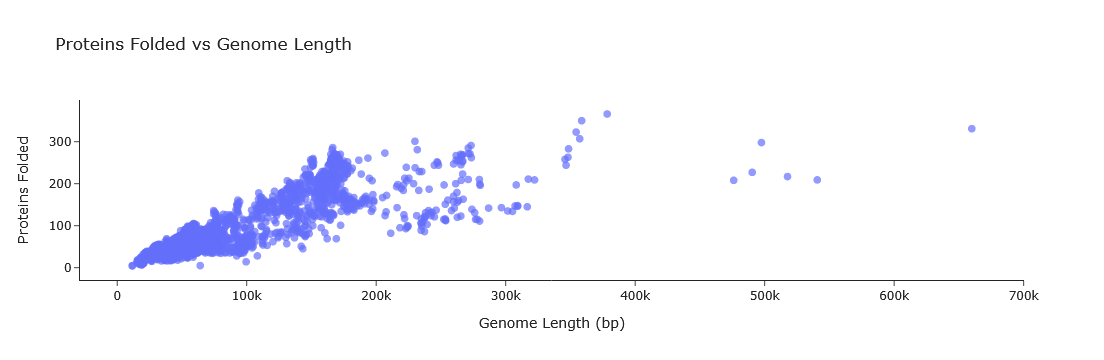

In [79]:
import plotly.express as px

fig = px.scatter(
    df,
    x='genome_length',
    y='proteins_folded',
    hover_name='genome_accn', 
    hover_data={
        'genome_name': True,
        'total_proteins': True,
        'taxonomy_string': False,  
    },
    labels={
        'genome_length': 'Genome Length (bp)',
        'proteins_folded': 'Proteins Folded'
    },
    title='Proteins Folded vs Genome Length'
)

fig.update_traces(marker=dict(size=8, opacity=0.7))
fig.update_layout(template='simple_white')

fig.show()

In [80]:
# pass this to R script to generate macro metadata about pdbs
df.to_csv('../data/4083_total_folded_per_genome.csv',index=False)

# TerLs excluded in first-pass analysis

## Identify and filter truncated TerLs - find proteins <0.5 of median cluster terminase protein lengths

Upon visual inspection of the protein structures from the original optimal clustering output (clu_c_40_mode_5_tm_30_original), a truncated terminase large subunit (TerL) was identified as the cluster representative for one of the TerL clusters (YP_009011901.1). Further manual inspection revealed additional truncated TerLs, which were subsequently identified and removed using the code below.


In [43]:
# result_cluster.tsv is the original clustering output without any TerLs removed
clu_c_40_mode_5_tm_30_original = pd.read_csv('../data/foldseek_easy_cluster/result_cluster.tsv',sep='\t',header=None)
clu_c_40_mode_5_tm_30_original = annotate_clusters(clu_c_40_mode_5_tm_30_original, metadata)

In [44]:
cluster_TerLs = clu_c_40_mode_5_tm_30_original[
    (clu_c_40_mode_5_tm_30_original.cluster_PFAM1_definition.str.contains('terminase large|RNaseH', case=False, na=False)) |
     (clu_c_40_mode_5_tm_30_original.cluster_function.str.contains('terminase large', case=False, na=False))
]
member_TerLs = clu_c_40_mode_5_tm_30_original[
    (clu_c_40_mode_5_tm_30_original.member_PFAM1_definition.str.contains('terminase large|RNaseH', case=False, na=False)) |
     (clu_c_40_mode_5_tm_30_original.member_function.str.contains('terminase large', case=False, na=False))
]

In [45]:
# median TerL size
member_TerLs['member_protein_length'].median()

547.0

In [46]:
# median TerL size
member_TerLs['member_protein_length'].median() / 2

273.5

In [ ]:
cluster_Terls_to_exclude = cluster_TerLs[cluster_TerLs.cluster_protein_length<273].drop_duplicates(subset='cluster')['cluster'].to_list()
member_Terls_to_exclude = member_TerLs[member_TerLs.member_protein_length<273].drop_duplicates(subset='members')['members'].to_list()

# Convert lists into DataFrames
df_cluster_exclude = pd.DataFrame({'protein_id': cluster_Terls_to_exclude})
df_member_exclude = pd.DataFrame({'protein_id': member_Terls_to_exclude})

# Concatenate both DataFrames into one
TerLs_exclude = pd.concat([df_cluster_exclude, df_member_exclude], ignore_index=True)
TerLs_exclude.to_csv('../data/terls_excluded.csv',index=False)